# Convolutional Neural Network (CNN): Fashion-MNIST

In [87]:
import struct

import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow.keras as keras
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping

In [74]:
# Load data
root = '../../Datasets/Fashion-MNIST/'
train_df = pd.read_csv(root + "/fashion-mnist_train.csv")
test_df = pd.read_csv(root + "/fashion-mnist_test.csv")

# Get X (scaled) and y
train_X = train_df.iloc[:, 1:].values
test_X = test_df.iloc[:, 1:].values
train_y = train_df.iloc[:, 0].values
test_y = test_df.iloc[:, 0].values

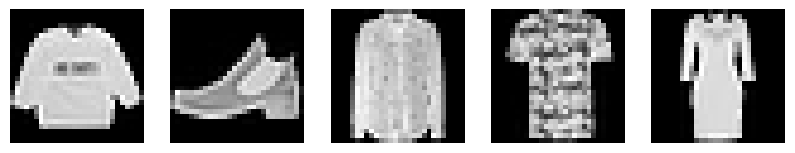

60000

10

In [75]:
# plot sample images
fig, axes = plt.subplots(1, 5, figsize=(10, 2))  
for i in range(5):
    axes[i].imshow(train_X[i].reshape(28, 28), cmap="gray")  # Reshape the 28x28 image and display it
    axes[i].axis('off')  # Hide the axes
plt.show()

# get some high-level stats
num_images, _ = train_X.shape
num_classes = len(np.unique(train_y))
display(num_images, num_classes)

#### Classes:

* 0 = T-shirt/top
* 1 = Trouser
* 2 = Pullover
* 3 = Dress
* 4 = Coat
* 5 = Sandal
* 6 = Shirt
* 7 = Sneaker
* 8 = Bag
* 9 = Ankle boot

In [76]:
# copy train_X and test_X to make them writable
train_X = np.copy(train_X.reshape(train_X.shape[0], 28, 28, 1).astype('float32'))
test_X = np.copy(test_X.reshape(test_X.shape[0], 28, 28, 1).astype('float32'))

# normalisation
train_X /= 255.0
test_X /= 255.0

# one-hot encode labels
train_y = np.eye(10)[train_y]
test_y = np.eye(10)[test_y]

In [77]:
# Data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,      # randomly rotate images up to 10 degrees
    zoom_range=0.1,         # randomly zoom image up to 10% 
    width_shift_range=0.1,  # randomly shift images horizontally up to 10%
    height_shift_range=0.1  # randomly shift images vertically up to 10%
    # horizontal_flip=False,  # randomly flip images horizontally
    # vertical_flip=False     # randomly flip images vertically
)
datagen.fit(train_X)

In [78]:
# build model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,213,610 (8.44 MB)

 Trainable params: 2,210,154 (8.43 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [79]:
# compile model
model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), 
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
)

In [ ]:
# fit model
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, # number of epochs to wait for improvement
    restore_best_weights=True # roll back to best model weights
)

history = model.fit(
    datagen.flow(train_X, train_y, batch_size=64), # only apply data augmentation on training set
    validation_data=(test_X, test_y), 
    epochs=20,
    callbacks=[early_stopping]
) 

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 33s 32ms/step - accuracy: 0.6891 - loss: 0.9785 - val_accuracy: 0.8644 - val_loss: 0.3776
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.8256 - loss: 0.4783 - val_accuracy: 0.8725 - val_loss: 0.3481
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.8450 - loss: 0.4181 - val_accuracy: 0.8809 - val_loss: 0.3043
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - accuracy: 0.8619 - loss: 0.3811 - val_accuracy: 0.9006 - val_loss: 0.2631
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.8716 - loss: 0.3508 - val_accuracy: 0.9012 - val_loss: 0.2649
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.8752 - loss: 0.3392 - val_accuracy: 0.9069 - val_loss: 0.2442
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.8807 - loss: 0.3210 - val_accuracy: 0.9122 - val_loss: 0.2461
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.8857 - loss: 0.3089 - 

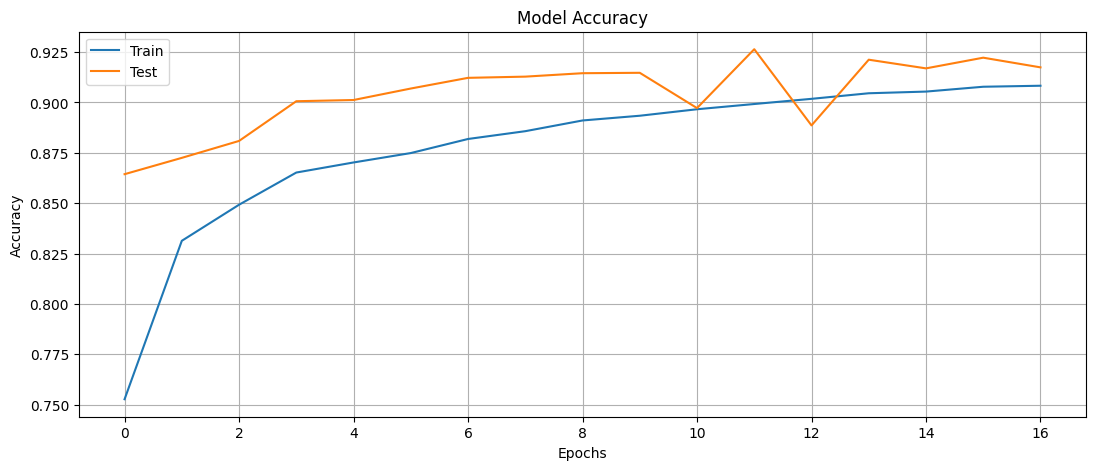

In [84]:
# evaluate model 
plt.figure(figsize=(13, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.grid()
plt.show()

In [85]:
# keras.utils.plot_model(
#     model,
#     to_file="nn-cnn-fashion-mnist-model.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=False,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=100,
#     show_layer_activations=True,
#     show_trainable=False
# )

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.9264
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.95      0.84      0.89      1000
           3       0.95      0.93      0.94      1000
           4       0.89      0.89      0.89      1000
           5       0.98      0.99      0.98      1000
           6       0.70      0.87      0.78      1000
           7       0.97      0.96      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.98      0.97      0.98      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



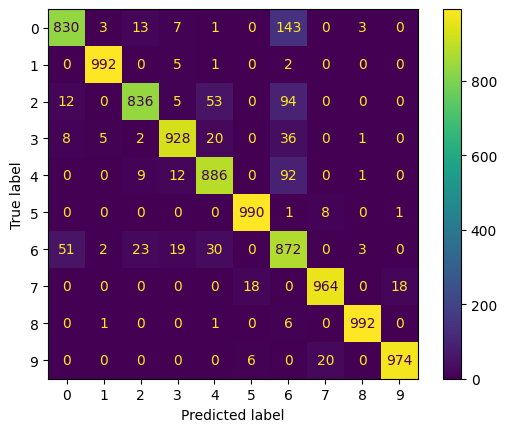

In [88]:
# evaluate
y_probs = model.predict(test_X)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(test_y, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

Misclassified = 736


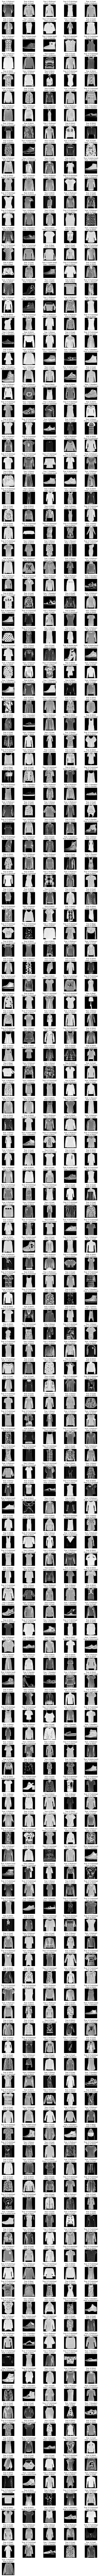

In [91]:
# evaluate misclassified images
misclassified = np.where(y_pred != y_true)[0]
num_miscl = len(misclassified)
print(f"Misclassified = {num_miscl}")

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

n_cols = 5
remainder = num_miscl % n_cols
n_rows = int(((num_miscl - remainder) / n_cols) + remainder)

plt.figure(figsize=(12, n_rows*2))
for i, idx in enumerate(misclassified[:num_miscl]):
    true_class_id = y_true[idx]
    true_class_name = classes[true_class_id]
    pred_class_id = y_pred[idx]
    pred_class_name = classes[pred_class_id]
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(test_X[idx].squeeze(), cmap='gray')
    plt.title(f"True: {true_class_id} ({true_class_name})\nPred: {pred_class_id} ({pred_class_name})")
    plt.axis('off')
plt.tight_layout()
plt.show()